In [1]:
import os
import sys

repo_root_path = os.path.abspath(os.path.join(os.path.pardir, 'hebbnets'))
if repo_root_path not in sys.path:
    sys.path.append(repo_root_path)

import matplotlib.pyplot as plt
%matplotlib nbagg

import numpy as np

from demo_utils import yeild_patch_batch, turn_input_weights_to_pilimg, place_pilimgs_in_grid
from hebbnets.hebbnets.hah_model import MultilayerHahNetwork

# Make image patch generator

In [2]:
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/3/39/GlarusAlps.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/38/M_Rainier.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/3c/Volc%C3%A1n_Chimborazo%2C_%22El_Taita_Chimborazo%22.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/0/06/Briesetal_bei_Briese.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/7/75/Florida_freshwater_swamp_usgov_image.jpg'
]

patch_size = [12, 12]

batch_o_patches_gen = yeild_patch_batch(
    image_urls,
    patch_size=patch_size,
    patch_stride=[3, 3],
    batch_size=5000
)

# Set up HAH network

In [3]:
input_layer_size = patch_size[0] * patch_size[1]
nodes_per_layer = [256]

hah_network = MultilayerHahNetwork(
    input_layer_size,
    nodes_per_layer,
    has_bias=False,
    act_type='relu',
    gamma=0.1
)

# Gather/whiten all patches

In [4]:
all_patches = np.vstack([
    np.array([p.ravel() / 255.0 for p in batch])
    for batch in batch_o_patches_gen
])

In [5]:
# Whitening image patches
all_patches -= 128
whiten_mat = np.linalg.pinv(all_patches.T.dot(all_patches))
all_patches_white = all_patches.dot(whiten_mat)

# Train network on batches of patches

In [6]:
hah_network.train(
    all_patches_white,
    num_epochs=3
)

# Visualize the learned recpetive fields

In [7]:
rf_picture = place_pilimgs_in_grid(
    turn_input_weights_to_pilimg(
        hah_network.layers[0],
        patch_size,
        whiten_mat
    )
)

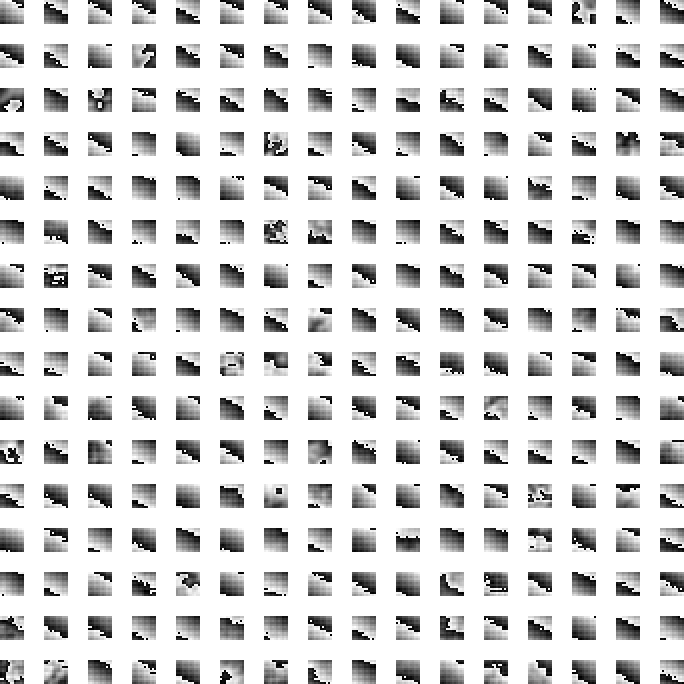

In [8]:
img_rescale = 2.0

rf_picture.resize(
    [int(img_rescale * i) for i in rf_picture.size],
)